In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
plt.style.use(["science","bright","grid"])

cm  = plt.get_cmap('cividis')
ma  = ["o","s","^","v","<",">"]

## DC Input - Voltage Distribution - Closed Circuit

In [2]:
def shift_and_append(dfs_dict):
    for name, df in dfs_dict.items():
        col1 = df.pop("1")  # remove column 1
        df.columns = range(df.shape[1])  # reassign column names to keep them sequential
        df[f"{len(df.columns)}"] = col1  # append column 1's data at the end
    return dfs_dict


# Parameter
folder      = "/home/j/j_mens07/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_size/"
N_voltages  = 50000
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40]

# Potentials
U_0_vals    = [pd.read_csv(f"{folder}Nx={N_p}_Ny=1_Ne=2.csv").loc[0,'E0'] for N_p in N_vals]
pot         = {N_p : pd.read_csv(f"{folder}mean_state_Nx={N_p}_Ny=1_Ne=2.csv") for N_p in N_vals}
pot         = shift_and_append(pot)
pot_eq      = pd.DataFrame([pot[N_p].iloc[45000:,:].mean().values / U_0_vals[i] for i, N_p in enumerate(N_vals)],index=N_vals).T.round(2)

# Output Current
out_curr    = {N_p : pd.read_csv(f"{folder}Nx={N_p}_Ny=1_Ne=2.csv")['Observable'].values for N_p in N_vals}

### Steady State

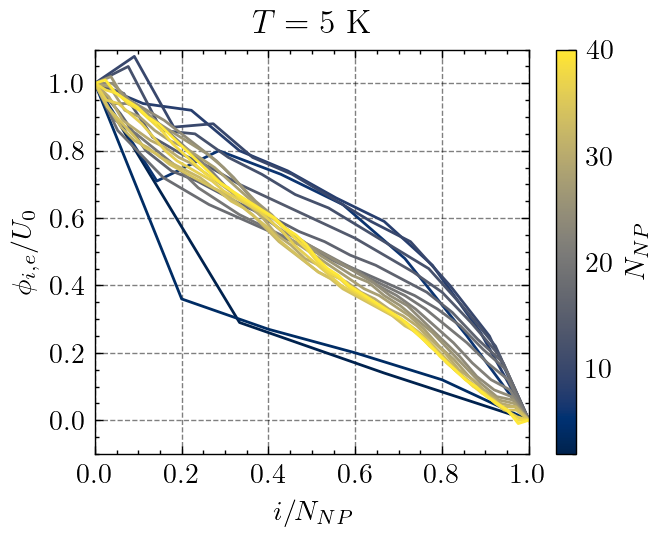

In [6]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    p   = pot_eq[N].dropna().values.copy()
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(N)))

ax.set_title(f"$T = 5$ K")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_potential.svg", transparent=True)

There are three distinct regions:
- Alternating Pattern (First NPs)
  - Electrons tunneling into the string repel each other, creating **oscillatory potentials**
  - Example:
    - NP0 charges to $\phi_0 \approx U_0$
    - NP1 receives an electron, lowering $\phi_1$ slightly compared to $\phi_0$
    - NP2 then sees a reduced bias, leading to $\phi_2 > \phi_1$
  - **Standing charge wave**, where single-electron hops create local potential minima/maxima
- Quasi-Linear Decay (Middle NPs)
  - ***Averaging over many charge hops***
    - As charges propagate, the discreteness effects smear out, resembling a linear response but at **quanized steps**
    - The slope $d\phi / dk$ reflects the **effective resistance** per NP
- Rapid Drop (Last NPs)
  - The grounded electrode strongly attracts electrons, accelerating the drop in $\phi_k$
  - Charges near the end tunnel more frequently due to the larger $\Delta \phi$

### Characteristic Time Scale

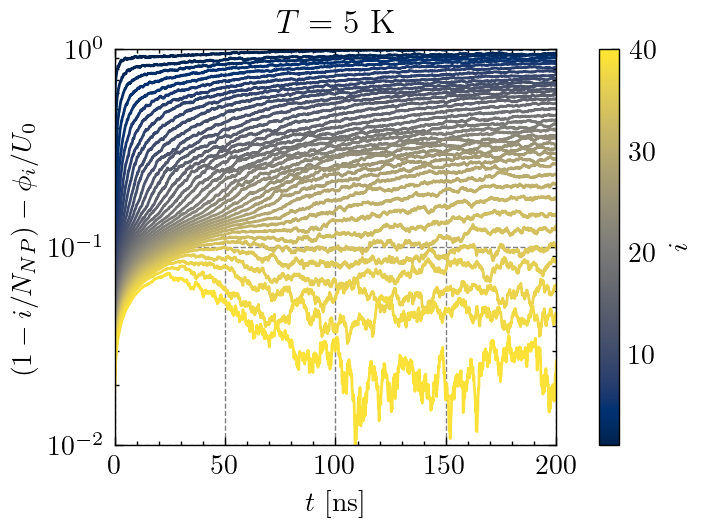

In [23]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
Np      = 40
i_U0    = np.where(np.array(N_vals)==Np)[0][0]
U_0     = U_0_vals[i_U0]
norm    = Normalize(vmin=1, vmax=Np)

for i in range(1,Np):
    ax.plot(t_vals, pot[Np][i].values/U_0, color=cm(norm(i)))

ax.set_title(f"$T = 5$ K")
ax.set_xlim(0,200)
ax.set_ylim(0.01,1)
ax.set_yscale('log')
ax.set_ylabel("$\\left(1-i/N_{NP}\\right) - \phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_time_series.svg", transparent=True)

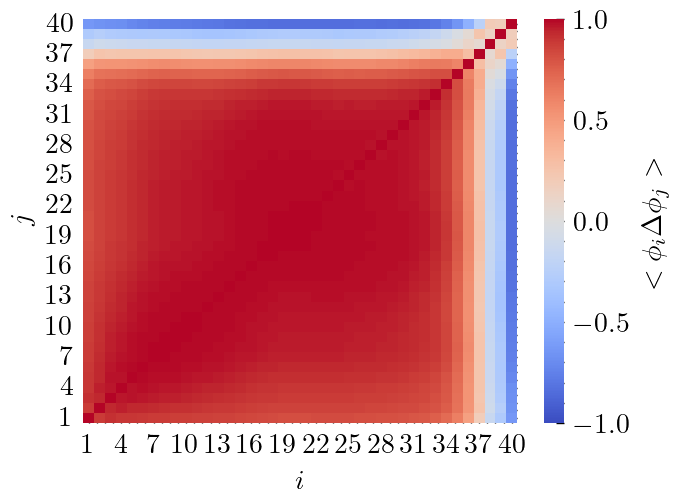

In [24]:
Np  = 40
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(pot[Np].iloc[:,1:-1].corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax,
                  cbar_kws={"label":"$<\phi_{i}\Delta\phi_{j}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$j$")
ax.invert_yaxis()
plt.yticks(rotation=0) 

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_pot_corr.svg", transparent=True)

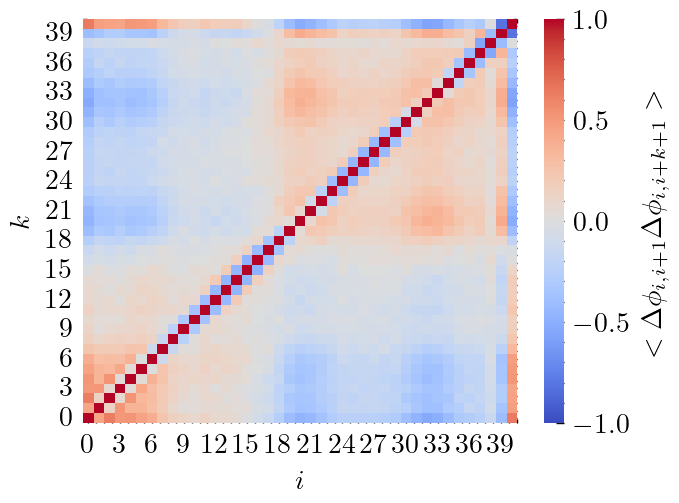

In [25]:
Np      = 40
p_diff  = pot[Np].diff(axis=1).drop(columns=0).values
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax,
                  cbar_kws={"label":"$<\Delta\phi_{i,i+1}\Delta\phi_{i,i+k+1}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")
ax.invert_yaxis()
plt.yticks(rotation=0) 

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_pot_diff_corr.svg", transparent=True)

- Alternating correlation signals local charge-density waves:
  - Electrons repel each other, creating a quasi-ordered pattern
  - Perfect order (Wigner crystallization) is disturbed due to thermal fluctuations and finite bias given $U_0$
- As the grounded electrode drains charges, we get enhancing correlations in the last few NPs

In [26]:
p_vals, cov_vals = {}, {}
for Np in N_vals:
    N, M            = Np + 1, 100
    p_tmp, cov_tmp  = [], []
    for k in range(1,N):

        def func(t, tau, t0, k, N, M):
            v_inf   = 1.0 - k / N
            n       = np.arange(1, M + 1)
            A_th    = (2.0 / np.pi) * (1.0 / n) * np.sin(np.pi * n * (k / float(N)))
            te      = np.maximum(t - t0, 0.0)
            E       = np.exp(-(n**2)[:, None] * (te[None, :] / tau))
            series  = (A_th[:, None] * E).sum(axis=0)
            return v_inf - series

        def helper(t, tau, t0):
            return func(t, tau, t0, k, N, M)

        i_U0    = np.where(np.array(N_vals)==(Np))[0][0]
        U_0     = U_0_vals[i_U0]
        t_test  = t_vals.copy()
        v_test  = pot[Np][k].values.copy()/U_0
        p, cov  = curve_fit(helper, t_test, v_test)

        p_tmp.append(p)
        cov_tmp.append(cov)

    p_vals[Np]      = np.array(p_tmp)
    cov_vals[Np]    = np.array(cov_tmp)

/tmp/ipykernel_10837/981177862.py:12: RuntimeWarning: overflow encountered in exp
  E       = np.exp(-(n**2)[:, None] * (te[None, :] / tau))
/home/j/j_mens07/.local/lib/python3.11/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


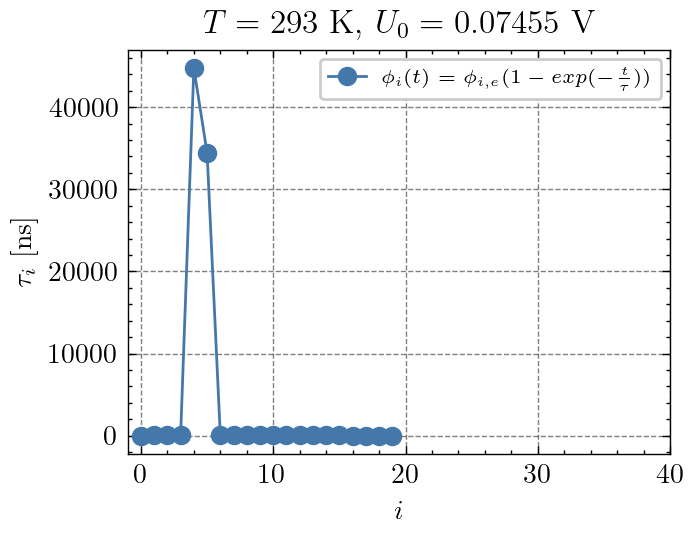

In [33]:
Np  = 20
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
xp  = range(Np)
ax.plot(xp, p_vals[Np][:,0], '-o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
# ax.plot(xp, tau_s_dict[Np], '-s', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.set_xlabel("$i$")
ax.set_ylabel("$\\tau_i$ [ns]")
# ax.set_ylim(0,150)
ax.set_xlim(-1,40)
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_time_scales.svg", transparent=True)

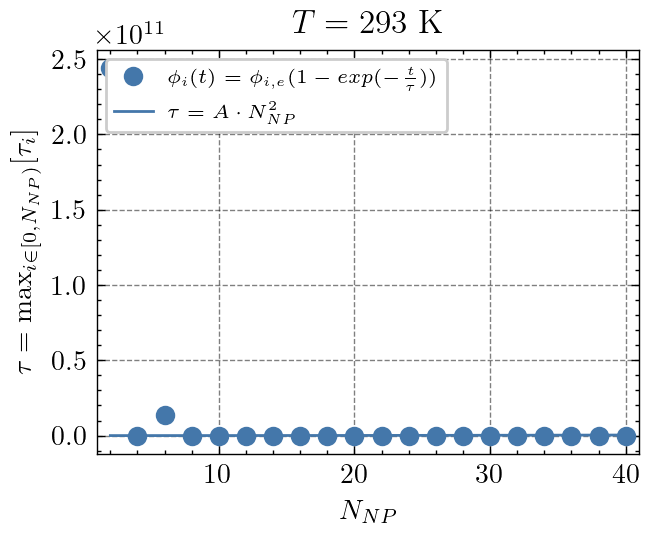

In [28]:
taus_max = [np.max(p_vals[Np][:,0]) for Np in N_vals]

def quad_func(x, a):
    return a*(x+1)**2

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
p,_ = curve_fit(quad_func, N_vals, taus_max)
pp  = ax.plot(N_vals, taus_max, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

ax.set_ylabel("$\\tau = \max_{i \in [0,N_{NP})}[\\tau_i]$")
ax.set_xlim(1,41)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small', loc='upper left')
ax.set_title(f"$T = 293$ K")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_time_scales_vs_N.svg", transparent=True)

In [17]:
def characteristic_time(t_vals, pot_df, Np, steady_start=40000, consecutive_points=50, p_th=0.63):

    end_vals    = pot_df[Np].iloc[steady_start:,:].mean().values
    taus        = []
    p_th        = 0.63

    for i in range(Np):
        vals        = pot_df[Np].loc[:,i].values
        threshold   = p_th*end_vals[i]
        above_th    = vals > threshold
        for j in range(len(above_th) - consecutive_points):
            if all(above_th[j:j+consecutive_points]):
                tau = t_vals[j]
                taus.append(tau)
                break
    
    return taus

def characteristic_time_saturation(t_vals, pot_df, Np, steady_start=6000):

    def saturation_cuve(t, tau, a0, t0):
        t_shift = np.clip(t - t0, 0, None)
        return a0*(1 - np.exp(-t_shift / tau))

    tau     = []
    params  = []
    for i in range(Np):
        x       = t_vals.copy()
        y       = pot_df[Np].loc[steady_start:,f'{i}'].values
        p, _    = curve_fit(saturation_cuve, x, y, bounds=((0,0,0),(np.inf,np.inf,np.inf)))
        tau.append(p[0])
        params.append(p)

    return tau, params

def characteristic_time_stretched_saturation(t_vals, pot_df, Np, p0):

    def stretched_saturation_curve(t, tau, a0, t0, beta):
        t_shift = np.clip(t - t0, 0, None)
        return a0*(1 - np.exp(-(t_shift/tau)**beta))

    tau     = []
    params  = []
    for i in range(Np):
        x       = t_vals.copy()
        y       = pot_df[Np].loc[:,f'{i}'].values
        p, _    = curve_fit(stretched_saturation_curve, x, y, p0=p0[i,:], bounds=((0,0,0,0),(np.inf,np.inf,np.inf,np.inf)),maxfev=10000)
        tau_val = gamma(1/p[3])*p[0]/p[3]
        tau.append(tau_val)
        params.append(p)
        # print(p)

    return tau, params

In [18]:
tau_dict    = {}
tau_s_dict  = {}

for Np in N_vals:

    # Single exponential
    # taus, params    = characteristic_time_saturation(t_vals, pot, Np)
    taus            = characteristic_time(t_vals, pot, Np)
    tau_dict[Np]    = taus

    # Stretched exponential
    # p0_vals                             = np.hstack((np.array(params),np.ones(shape=(Np,1))))
    # taus_stretched, params_stretched    = characteristic_time_stretched_saturation(t_vals, pot, Np, p0_vals)
    # tau_s_dict[Np]                      = taus_stretched

taus_max    = [np.max(tau_dict[Np]) for Np in N_vals]
# taus_s_max  = [np.max(tau_s_dict[Np]) for Np in N_vals]

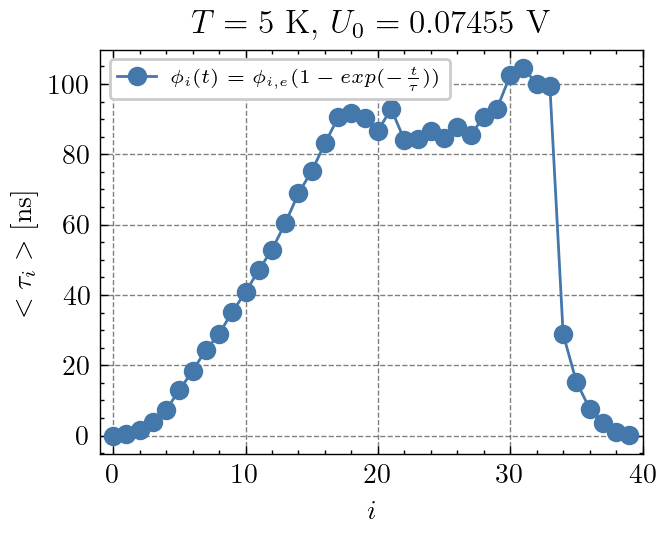

In [19]:
Np  = 40
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
xp  = range(Np)
ax.plot(xp, tau_dict[Np], '-o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
# ax.plot(xp, tau_s_dict[Np], '-s', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.set_xlabel("$i$")
ax.set_ylabel("$<\\tau_i>$ [ns]")
# ax.set_ylim(0,300)
ax.set_xlim(-1,40)
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_time_scales.svg", transparent=True)

In [30]:
R_eff = (np.array(taus_max)*np.pi**2)/(Cs*(np.array(N_vals)+1)**2)

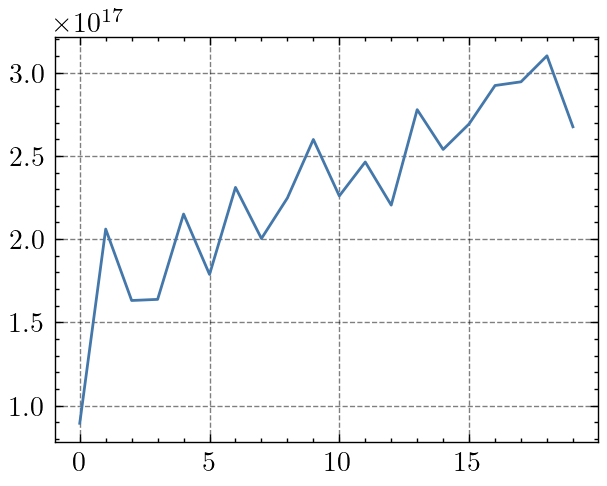

In [ ]:
fig, ax = plt.subplots(dpi=200)
ax.plot(R_eff)

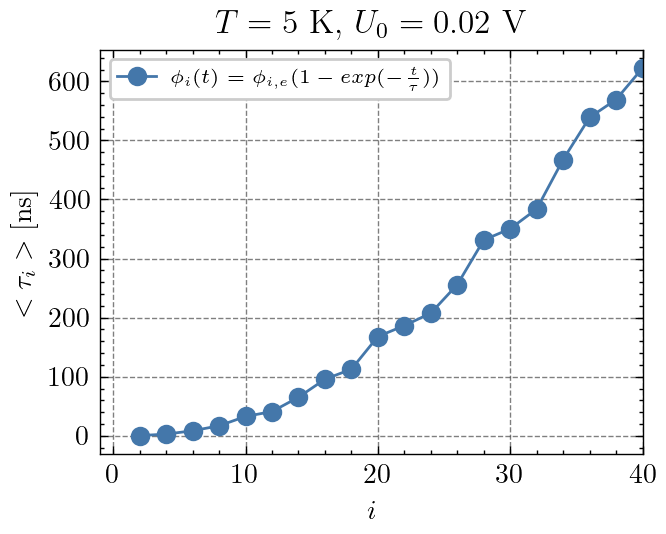

In [58]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(N_vals, taus_max, '-o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
# ax.plot(N_vals, taus_s_max, '-s', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.set_xlabel("$i$")
ax.set_ylabel("$<\\tau_i>$ [ns]")
# ax.set_ylim(0,300)
ax.set_xlim(-1,40)
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_time_scales_vs_N.svg", transparent=True)

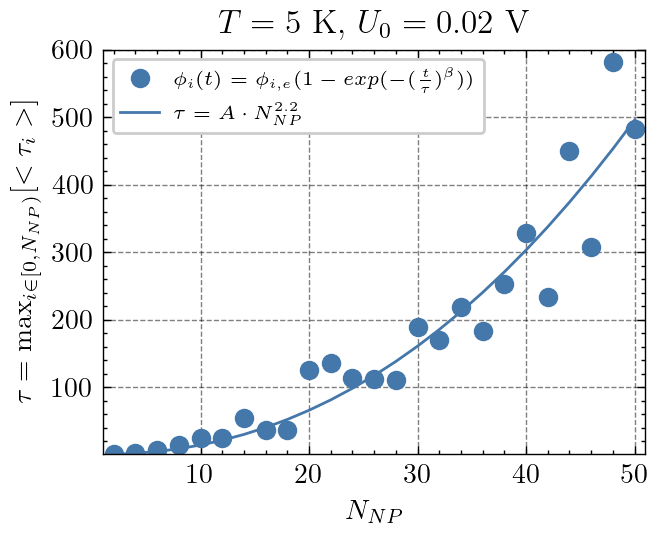

In [103]:
def quad_func(x, a):
    return a*x**2

def pol_func(x, a, b):
    return a*x**b

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

# p,_ = curve_fit(pol_func, N_vals, tau_s)
# pp  = ax.plot(N_vals, tau_s, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
# ax.plot(N_vals, pol_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^{"+f"{np.round(p[1],1)}"+"}$")
# ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^{2}$")

p,_ = curve_fit(pol_func, N_vals, tau_s_stretched)
pp  = ax.plot(N_vals, tau_s_stretched, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.plot(N_vals, pol_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^{"+f"{np.round(p[1],1)}"+"}$")

# ax.plot(N_vals, quad_func(np.array(N_vals), R*(2*Cm+Cs)*1e9 / (np.pi**2)), color='black', label="$\\tau = \\frac{R \cdot (2C_m + C_s)}{\pi^2} \cdot N_{NP}^2$")

# ax.set_ylabel("$\\underset{i \in [0,N_{NP})}{\max} <\\tau_i>$")
ax.set_ylabel("$\\tau = \max_{i \in [0,N_{NP})}[<\\tau_i>]$")
ax.set_ylim(1,600)
ax.set_xlim(1,51)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")
# ax.set_xscale('log')
# ax.set_yscale('log')

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_time_scales_vs_N.svg", transparent=True)

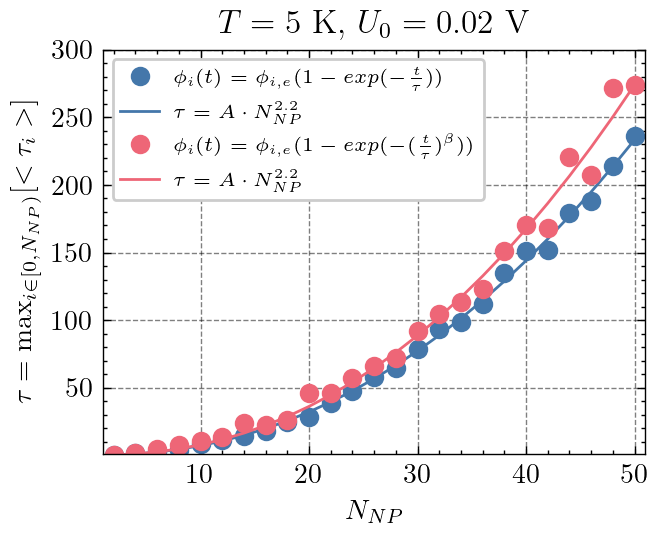

In [98]:
def quad_func(x, a):
    return a*x**2

def pol_func(x, a, b):
    return a*x**b

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

p,_ = curve_fit(pol_func, N_vals, tau_s_means)
pp  = ax.plot(N_vals, tau_s_means, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(N_vals, pol_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^{"+f"{np.round(p[1],1)}"+"}$")

p,_ = curve_fit(pol_func, N_vals, tau_s_stretched_means)
pp  = ax.plot(N_vals, tau_s_stretched_means, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.plot(N_vals, pol_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^{"+f"{np.round(p[1],1)}"+"}$")

# ax.plot(N_vals, quad_func(np.array(N_vals), R*(2*Cm+Cs)*1e9 / (np.pi**2)), color='black', label="$\\tau = \\frac{R \cdot (2C_m + C_s)}{\pi^2} \cdot N_{NP}^2$")

# ax.set_ylabel("$\\underset{i \in [0,N_{NP})}{\max} <\\tau_i>$")
ax.set_ylabel("$\\tau = \max_{i \in [0,N_{NP})}[<\\tau_i>]$")
ax.set_ylim(1,300)
ax.set_xlim(1,51)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")
# ax.set_xscale('log')
# ax.set_yscale('log')

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_time_scales_vs_N.svg", transparent=True)

- Charges move via **rare, stochastic hops** (like a random walk with waiting times)
- Each hop requires overcoming Coulomb repulsion from neighboring charges: **Barrier accumulation**
- Charges cannot overtake, creating bottlenecks: **Single-file motion**
- **Fractional diffusion:**
  - In classical diffusion, displacement $\Delta x ~ \sqrt{t}$
  - Now disorder and interactions slow propagation, leading to $\Delta x ~ t^{1/2.5} \rightarrow \tau ~ N^{2.5}$ --> **Subdiffusion**

(1.0, 51.0)

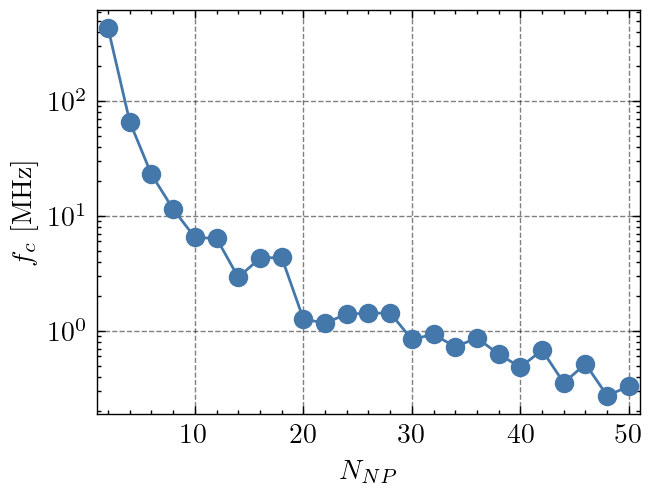

In [101]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(N_vals,1000/(2*np.pi*np.array(tau_s_stretched)), 'o-')
ax.set_yscale('log')
ax.set_ylabel("$f_c$ [MHz]")
ax.set_xlabel("$N_{NP}$")
ax.set_xlim(1,51)

Text(0.5, 0, '$t$ [ns]')

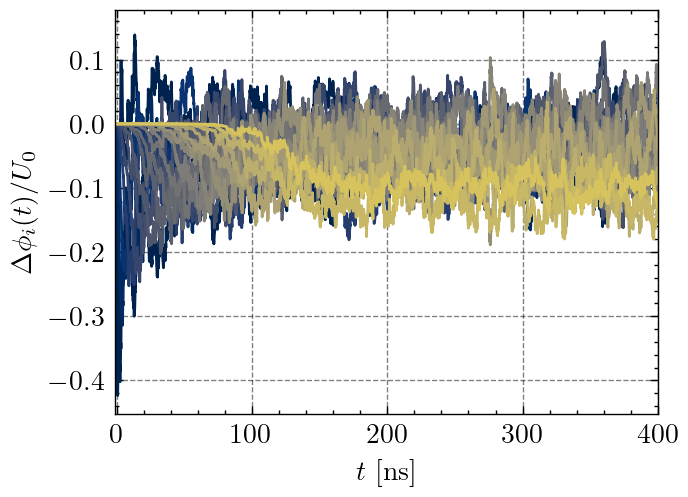

In [42]:
Np      = 20
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np-1):
    ax.plot(t_f_d, p_diff[:,i]/U_0, color=cm((i-1)/Np), label=f'${i}$')
ax.set_xlim(-1,400)
ax.set_ylabel("$\Delta \phi_i(t) / U_0$")
ax.set_xlabel("$t$ [ns]")
# ax.legend(fontsize='x-small', ncol=2)

## DC Input - Voltage Distribution - Open Circuit

In [106]:
# folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/"
folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/"
N_voltages  = 50000
U_0         = 0.02
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
N_vals      = [2,4,6,8,9,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
pot         = {N_p : pd.read_csv(f"{folder}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_eq      = pd.DataFrame([pot[N_p].iloc[48000:,:].mean().values / U_0 for N_p in N_vals],index=N_vals).T.round(2)

In [107]:
cap_matrix          = {}
inv_cap_matrix      = {}
for N_p in N_vals:
    topology_parameter  = {
        "Nx"                : N_p,
        "Ny"                : 1,
        "Nz"                : 1,
        "e_pos"             : [[0,0,0],[N_p-1,0,0]],
        "electrode_type"    : ['constant','floating']
    }
    sim_class           = nanonets.simulation(topology_parameter=topology_parameter, high_C_output=False)
    cap_matrix[N_p]     = sim_class.capacitance_matrix
    inv_cap_matrix[N_p] = sim_class.inv_capacitance_matrix

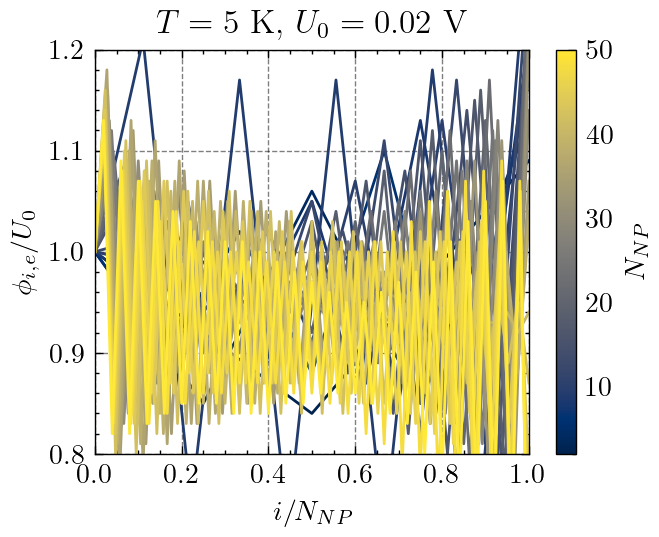

In [108]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    p   = pot_eq[N].dropna().values.copy()
    p   = np.insert(p, 0, 1.0)
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(N)))

ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")
ax.set_ylim(0.8,1.2)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/nonlinear/open_circuit_node_potential.svg", transparent=True)

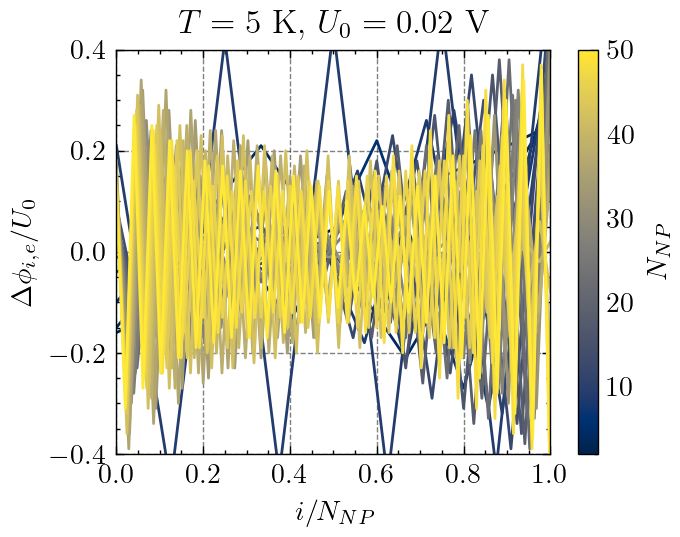

In [109]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    arr = pot_eq[N].dropna().values.copy()*U_0
    arr = np.insert(arr, 0, U_0)
    arr = np.diff(arr)/U_0
    x   = np.linspace(0,1,len(arr))

    ax.plot(x, arr, color=cm(norm(N)))

ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")
ax.set_xlim(0,1)
ax.set_ylim(-0.4, 0.4)
ax.set_ylabel("$\Delta \phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/nonlinear/open_circuit_node_potential_difference.svg", transparent=True)

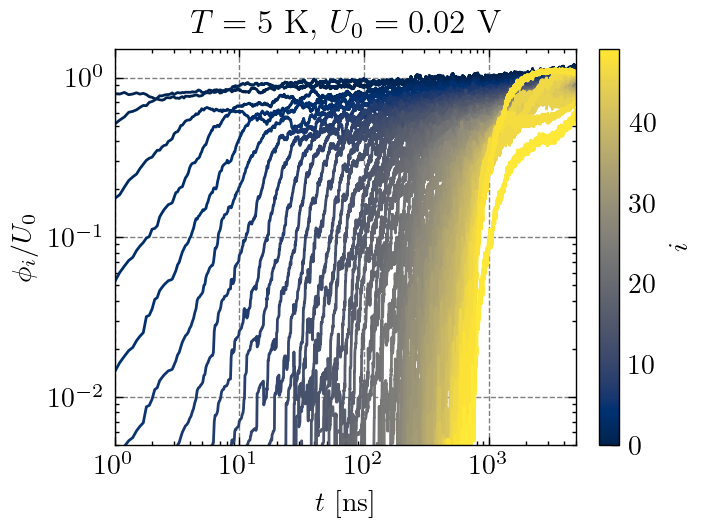

In [116]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
Np      = 50
norm    = Normalize(vmin=0, vmax=Np-1)

for i in range(Np):
    ax.plot(t_vals, pot[Np][f"{i}"].values/U_0, color=cm(norm(i)))

ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")
ax.set_xlim(1,5000)
ax.set_ylim(0.005,1.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

fig.savefig("../plots/dc_input/nonlinear/open_circuit_node_time_series.svg", transparent=True)

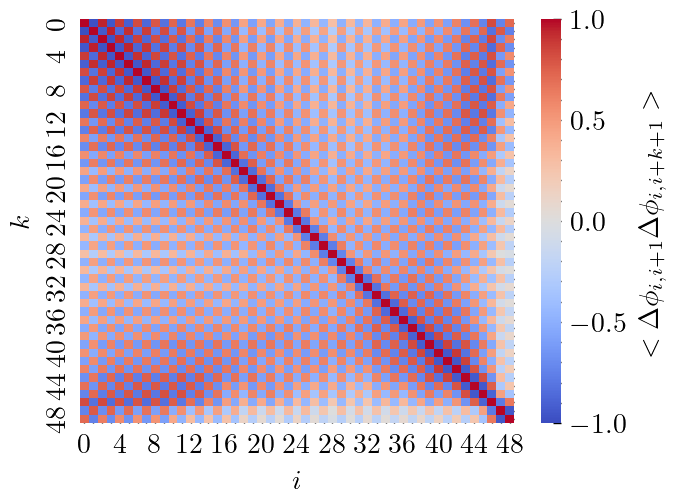

In [117]:
Np      = 50
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax,
                  cbar_kws={"label":"$<\Delta\phi_{i,i+1}\Delta\phi_{i,i+k+1}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")

fig.savefig("../plots/dc_input/nonlinear/open_circuit_node_pot_diff_corr.svg", transparent=True)

In [123]:
Np                                          = 50
taus_hot, params_hot                        = characteristic_time_saturation(t_vals, pot, Np)
p0_vals                                     = np.hstack((np.array(params_hot),np.ones(shape=(50,1))))
taus_hot_stretched, params_hot_stretched    = characteristic_time_stretched_saturation(t_vals, pot, Np, p0_vals)

/home/j/j_mens07/.local/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: divide by zero encountered in divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm


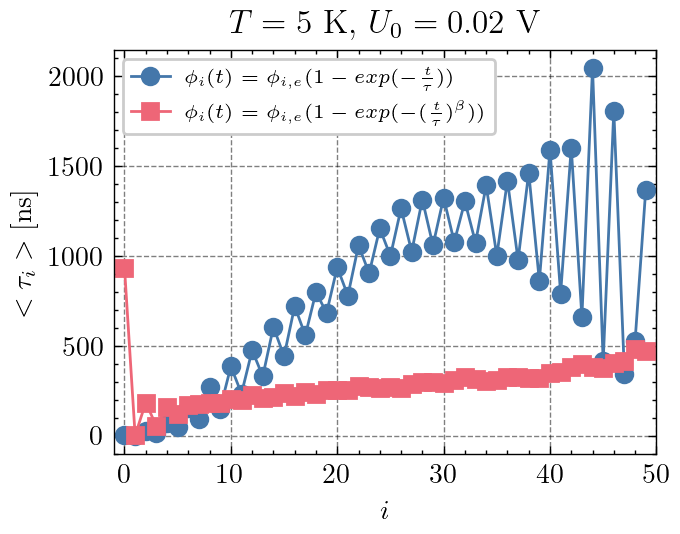

In [120]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
xp  = range(Np)
ax.plot(xp, taus_hot, '-o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(xp, taus_hot_stretched, '-s', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.set_xlabel("$i$")
ax.set_ylabel("$<\\tau_i>$ [ns]")
# ax.set_ylim(0,200)
ax.set_xlim(-1,Np)
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/nonlinear/open_circuit_node_time_scales.svg", transparent=True)

In [ ]:
def stretched_saturation_curve(t, tau, a0, t0, beta):
    t_shift = np.clip(t - t0, 0, None)
    return a0*(1 - np.exp(-(t_shift/tau)**beta))
def saturation_cuve(t, tau, a0, t0):
    t_shift = np.clip(t - t0, 0, None)
    return a0*(1 - np.exp(-t_shift / tau))

i = 0
y = pot[50].iloc[:,i].values

fig = plt.figure(dpi=200)
ax  = fig.add_subplot() 
ax.plot(t_vals, y)
ax.plot(t_vals, saturation_cuve(t_vals, *params_hot[i]))
ax.plot(t_vals, stretched_saturation_curve(t_vals, *params_hot_stretched[i]))
ax.set_xlim(-10, 1000)

In [114]:
tau_s               = []
tau_s_stretched     = []

for Np in N_vals:
    taus, std   = characteristic_time_saturation(t_vals, pot, Np)
    tau_s.append(np.max(taus))
    # taus        = characteristic_time_stretched_saturation(t_vals, pot, Np)
    # tau_s_stretched.append(np.max(taus))

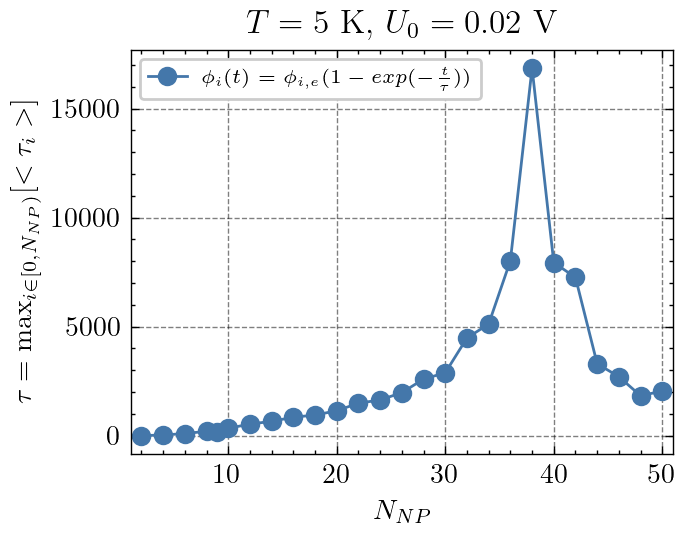

In [115]:
def quad_func(x, a):
    return a*x**2

def pol_func(x, a, b):
    return a*x**b

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

p,_ = curve_fit(pol_func, N_vals[:-6], tau_s[:-6])
pp  = ax.plot(N_vals, tau_s, '-o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
# ax.plot(N_vals[:-6], pol_func(np.array(N_vals[:-6]), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

# p,_ = curve_fit(quad_func, N_vals, tau_s_stretched)
# pp  = ax.plot(N_vals, tau_s_stretched, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
# ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

# ax.plot(N_vals, quad_func(np.array(N_vals), R*Cm*1e9), color='black', label="$\\tau = RC \cdot N_{NP}^2$")

# ax.set_ylabel("$\\underset{i \in [0,N_{NP})}{\max} <\\tau_i>$")
ax.set_ylabel("$\\tau = \max_{i \in [0,N_{NP})}[<\\tau_i>]$")
# ax.set_ylim(0,60)
ax.set_xlim(1,51)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/nonlinear/open_circuit_time_scales_vs_N.svg", transparent=True)

[Text(0.5, 0, ''),
 Text(3334.5, 0, ''),
 Text(6668.5, 0, ''),
 Text(10002.5, 0, ''),
 Text(13336.5, 0, ''),
 Text(16670.5, 0, ''),
 Text(20004.5, 0, ''),
 Text(23338.5, 0, ''),
 Text(26672.5, 0, ''),
 Text(30006.5, 0, ''),
 Text(33340.5, 0, ''),
 Text(36674.5, 0, ''),
 Text(40008.5, 0, ''),
 Text(43342.5, 0, ''),
 Text(46676.5, 0, '')]

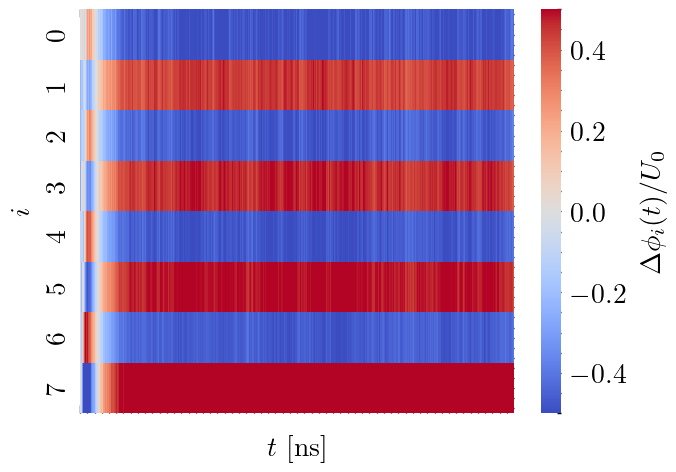

In [153]:
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
p_diff  = pd.DataFrame(p_diff, index=np.round(np.arange(N_voltages)*1e-10*1e6,4))
p_diff

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(p_diff.T/U_0, cmap='coolwarm', vmin=-0.5, vmax=0.5,
                  cbar_kws={"label":"$\Delta \phi_i(t) / U_0$"})
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$i$")
ax.set_xticklabels("")

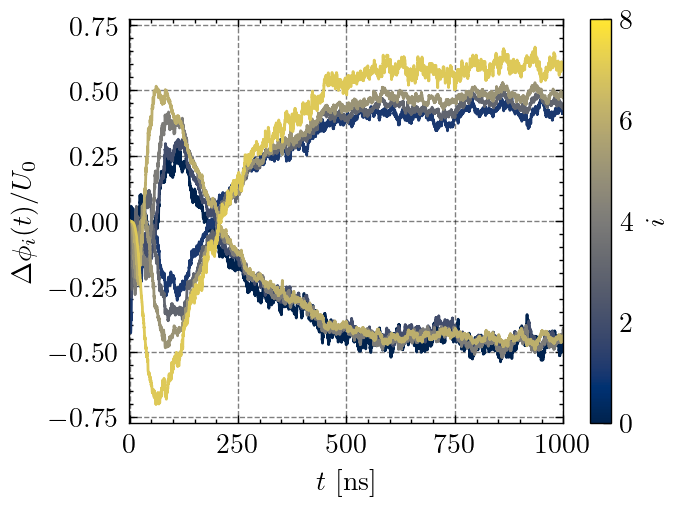

In [156]:
Np      = 9
norm    = Normalize(vmin=0, vmax=(Np-1))
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np-1):
    ax.plot(t_f_d, p_diff[:,i]/U_0, color=cm(norm(i)), label=f'${i}$')
ax.set_xlim(-1,1000)
ax.set_ylabel("$\Delta \phi_i(t) / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

fig.savefig("../plots/dc_input/nonlinear/open_circuit_node_diff_time_series.svg", transparent=True)
# ax.legend(fontsize='x-small', ncol=2)

In [182]:
Np  = 40
Q_t = np.zeros_like(pot[Np].values)
C   = cap_matrix[Np]
C_i = inv_cap_matrix[Np]
for t in range(pot[Np].values.shape[0]):
    Q_t[t, :] = C @ pot[Np].values[t, :]

# Total injected charge (relative to t=0)
Q_total = np.sum(Q_t - Q_t[0, :], axis=1)  # Shape: (N_T,)
P       = Q_t[-1, 1:] - Q_t[-1, :-1]

E_t = np.zeros(pot[Np].values.shape[0])
for t in range(pot[Np].values.shape[0]):
    E_t[t] = 0.5 * Q_t[t, :].T @ C_i @ Q_t[t, :]

Text(0, 0.5, '$P_i$')

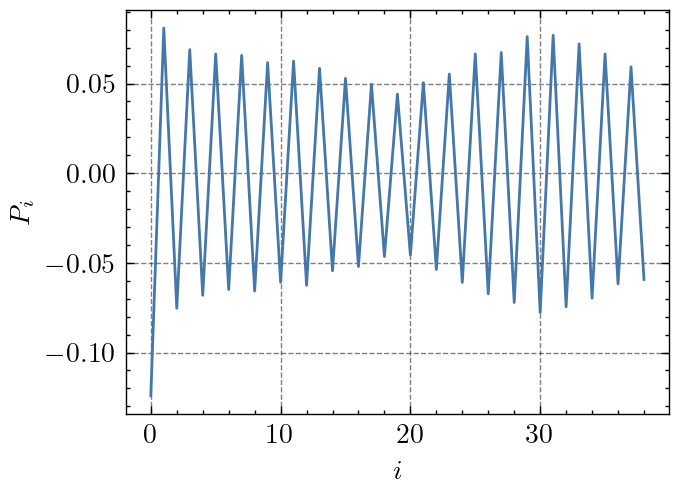

In [185]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(P)
ax.set_xlabel("$i$")
ax.set_ylabel("$P_i$")

Text(0, 0.5, '$Q_{total}$ [C]')

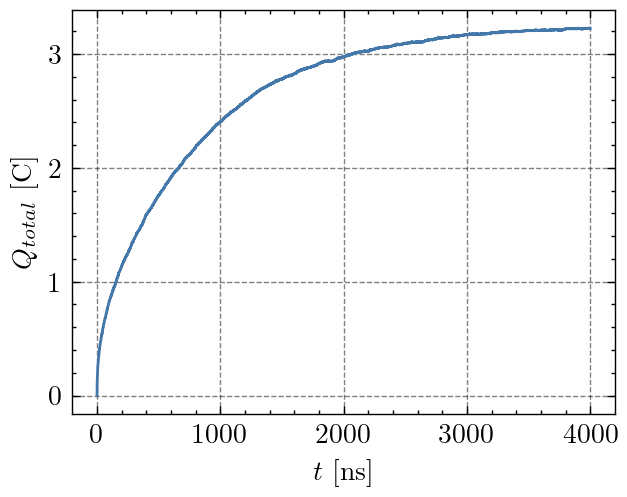

In [192]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(t_vals,Q_total)
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$Q_{total}$ [C]")

Text(0, 0.5, '$E$ [J]')

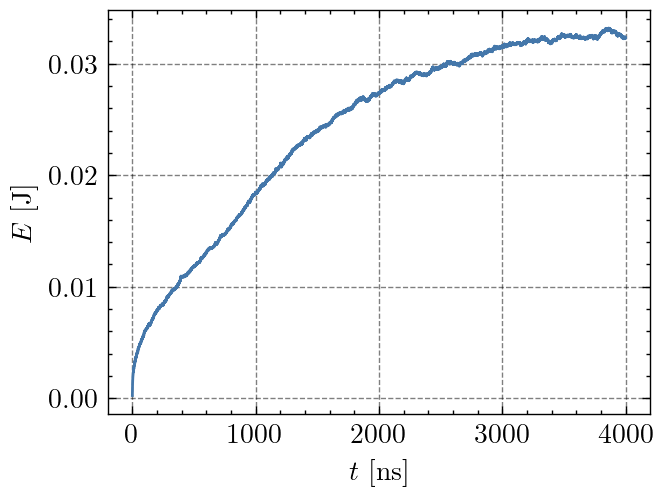

In [193]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(t_vals,E_t)
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$E$ [J]")

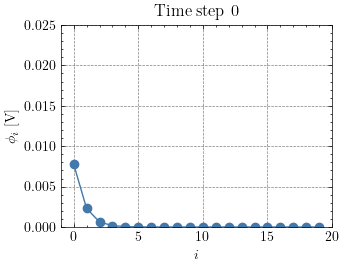

In [207]:
Np      = 20
p_anni  = pot[Np].values.copy()[:5000,:]
fig, ax = plt.subplots()
ax.set_xlabel('$i$')
ax.set_ylabel('$\phi_i$ [V]')
ax.set_ylim(np.min(pot[Np].values), np.max(pot[Np].values))
ax.set_xlim(-1, Np)
line, = ax.plot([], [], 'o-')

def update(frame):
    line.set_data(np.arange(Np), pot[Np].values[frame, :])
    ax.set_title(f'Time step {frame}')
    return line,

ani = FuncAnimation(fig, update, frames=pot[Np].values.shape[0], interval=10, blit=True)

In [ ]:
ani.save("test.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


---